<a href="https://colab.research.google.com/github/diego-carabajal/labo2025v/blob/main/src/rpart/201_ComparandoModelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparando Modelos

Estamos en la  Clase 02
<br> El objetivo de la materia es lograr la mejor predicción para nuestro probleama, para lo que se probarán pipelines con decenas de alternativas, será indispensable comparar varios modelos predictivos entre sí y decidir cual es el mejor
<br> La tarea no es tan sencilla

## Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [1]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Mounted at /content/.drive


Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [2]:
%%shell

mkdir -p "/content/.drive/My Drive/labo1"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/labo1" /content/buckets/b1

mkdir -p ~/.kaggle
cp /content/buckets/b1/kaggle/kaggle.json  ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/austral2025-af91/dataset_pequeno.csv"
archivo_destino="/content/datasets/dataset_pequeno.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/dataset_pequeno.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


# 1  Particion Training/Testing
## Clase 02  Experimento 1

## 1.1  Objetivos
Dado que es el primer experimento de la asignatura, acercar a l@s estudiantes las mejores prácticas de operación del ambiente de Google Cloud, realizando una minuciosa demostración en vivo narrando todas las consideraciones pertinentes para evitar accidentes, daños a terceros y a equipos.
Dar soporte en el acto a  l@s estudiantes que necesitan ayuda para terminar de configurar el ambiente Google Cloud .
<br>Repaso del concepto de  partición de un dataset al azar, estratificada en la clase
<br>Dado que es el primer script que se mostrará en vivo a l@s estudiantes,  realizar una visita guiada del  mismo, su estructura y detalles.
<br>Repaso del algoritmo Arbol de Decisión sus hiperparámetros, y la implementación con la librería  rpart.  Funciones  rpart::rpart  y rpart::predict
<br>Concepto de replicabilidad de los experimentos mediante las semillas de los generadores de secuencias de números pseudoaleatorios.
<br>Finalmente, el principal objetivo de este experimento es lograr que l@s estudiantes dimensionen la enorme variabilidad del error de medición de la ganancia de un árbol de decisión al realizar una partición <training, testing>,  contener la sorpresa de los estudiantes, descartar a la simple particion <training, testing> como método,  y construir en conjunto una solucion natural al problema.

## 1.2 Introduccion

![Particiohn Training/Testing](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E1_particion.jpg)

![Dos tipos de error](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E1_target.jpg)

## 1.3  Bibliografía

Demšar, J. [Statistical comparisons of classifiers over multiple data sets](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf) J. Mach. Learn. Res. 7, 1–30 (2006).   
Starmer, J. [Machine Learning Fundamentals: Cross Validation](https://www.youtube.com/watch?v=fSytzGwwBVw)Machine Learning Fundamentals: Cross Validation, StatQuest with Josh Starmer youtube channel, (2018)
Hastie, T.[The elements of statistical learning: data mining, inference, and prediction](https://hastie.su.domains/Papers/ESLII.pdf) , volume 2. Springer, 2009  ( Chapter 7 Model Assessment and Selection )

## 1.4 Codigo

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [1]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657245,35.2,1454451,77.7,1326126,70.9
Vcells,1220272,9.4,8388608,64.0,1975127,15.1


In [2]:
Sys.time()

[1] "2025-10-05 15:01:52 UTC"

* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [3]:
# cargo las librerias que necesito
require("data.table")
require("rpart")


Loading required package: data.table

Loading required package: rpart



###  Accion a Realizar
PARAM$semilla  debe tener su primer semilla aleatoria

In [4]:
PARAM <- list()
PARAM$semilla <- 100109  # aqui debe ir su primer semilla
PARAM$training_pct <- 70L  # entre  1L y 99L

PARAM$rpart <- list (
  "cp" = -1, # complejidad minima
  "minsplit" = 170, # minima cantidad de regs en un nodo para hacer el split
  "minbucket" = 70, # minima cantidad de regs en una hoja
  "maxdepth" = 7 # profundidad máxima del arbol
)


In [5]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [6]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp201"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [7]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [8]:
# particiono estratificadamente el dataset 70%, 30%
particionar(dataset,
  division = c(PARAM$training_pct, 100L -PARAM$training_pct),
  agrupa = "clase_ternaria",
  seed = PARAM$semilla # aqui se usa SU semilla
)



In [9]:
# genero el modelo
# quiero predecir clase_ternaria a partir del resto
# fold==1  es training,  el 70% de los datos
modelo <- rpart("clase_ternaria ~ .",
  data = dataset[fold == 1],  # fold==1  es training, el 70% de los datos
  xval = 0,
  control = PARAM$rpart # aqui van los parametros
)


In [10]:
# aplico el modelo a los datos de testing
prediccion <- predict(modelo, # el modelo que genere recien
  dataset[fold == 2], # fold==2  es testing, el 30% de los datos
  type = "prob"
) # type= "prob"  es que devuelva la probabilidad


In [11]:
tb_prediccion <- as.data.table(list(
  "clase_ternaria"=dataset[fold == 2, clase_ternaria],
  "prob"=prediccion[, "BAJA+2"]
))

In [12]:
# calculo la ganancia de cada registro
tb_prediccion[, ganancia := ifelse(clase_ternaria == "BAJA+2", 117000, -3000)]

In [13]:
# calculo la clase
tb_prediccion[, Predicted := prob > (1/40) ]

In [14]:
ganancia_test <-  tb_prediccion[ Predicted==TRUE,  sum(ganancia)]

In [15]:
# normalizo la ganancia
ganancia_test_normalizada <- ganancia_test / (( 100 - PARAM$training_pct ) / 100 )

In [16]:
estimulos <- tb_prediccion[ Predicted==TRUE, .N]
aciertos <- tb_prediccion[ Predicted & clase_ternaria == "BAJA+2", .N]


In [17]:
# Resultado Final
cat("Testing total: ", dataset[fold == 2, .N], "\n")
cat("Testing BAJA+2: ", dataset[fold == 2 & clase_ternaria == "BAJA+2", .N], "\n")

cat("Estimulos: ", estimulos, "\n")
cat("Aciertos (BAJA+2): ", aciertos, "\n")

cat("Ganancia en testing (normalizada): ", ganancia_test_normalizada, "\n")


Testing total:  49378 
Testing BAJA+2:  374 
Estimulos:  2783 
Aciertos (BAJA+2):  188 
Ganancia en testing (normalizada):  47370000 


### Acciones a realizar
* Reportar la  *Ganancia en testing (normalizada)* <br> en la planilla colaborativa hoja  **C2-1sem**
* Se discutirá en clase la variabilidad de las ganancias obtenidas de distintos alumnos



---



# 2  Medición Monte Carlo Cross Validation
## Clase 02  Experimento 2

## 2.1  Objetivos
Mostrar el funcionamiento de la Montecarlo Cross Validation y que l@s estudiantes aprecien la disminución de la varianza de dicha metodología.
Relación con el Teorema Central del Límite

## 2.2 Introduccion

![Montecarlo](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E2_montecarlo.jpg)

![Curva normal](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E2_normal.jpg)

![Teorema Central del Limite](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E2_teoremacentralLimite.jpg)



## 2.3  Bibliografía

Demšar, J. [Statistical comparisons of classifiers over multiple data sets](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf) J. Mach. Learn. Res. 7, 1–30 (2006).   
Starmer, J. [Machine Learning Fundamentals: Cross Validation](https://www.youtube.com/watch?v=fSytzGwwBVw)Machine Learning Fundamentals: Cross Validation, StatQuest with Josh Starmer youtube channel, (2018)
Hastie, T.[The elements of statistical learning: data mining, inference, and prediction](https://hastie.su.domains/Papers/ESLII.pdf) , volume 2. Springer, 2009  ( Chapter 7 Model Assessment and Selection )

## 2.4 Codigo  Montecarlo

El código de la Montecarlo Cross Validation es notablemente más complejo que el anterior de una simple partición training/testing
<br> Se crea la funcion ArbolEstimarGanancia()  que dada una semilla realiza la partición  training/testing, entrena en training, aplica el modelo a testing, y se calculan las ganancias
<br> Se utiliza la funcion **mcmapply**  de R para aplicar ArbolEstimarGanancia a todos los elementos del vector de semillas

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [18]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,744946,39.8,1454451,77.7,1454451,77.7
Vcells,1412355,10.8,84907202,647.8,104118852,794.4


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [19]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

Loading required package: parallel



###  Accion a Realizar
PARAM$semillas  debe tener sus cinco semillas aleatorias

In [20]:
PARAM <- list()
PARAM$semillas <- c(100109, 100129, 100153, 100169, 100189)  # aqui debe ir sus CINCO
PARAM$training_pct <- 70L  # entre  1L y 99L

PARAM$rpart <- list (
  "cp" = -1, # complejidad minima
  "minsplit" = 170, # minima cantidad de regs en un nodo para hacer el split
  "minbucket" = 70, # minima cantidad de regs en una hoja
  "maxdepth" = 7 # profundidad máxima del arbol
)


In [21]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [22]:

ArbolEstimarGanancia <- function(semilla, param_basicos) {
  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(param_basicos$training_pct, 100L -param_basicos$training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_basicos$rpart
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion <- predict(modelo, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad

  # prediccion es una matriz con TRES columnas,
  #  llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
  # cada columna es el vector de probabilidades


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test <- dataset[
    fold == 2,
    sum(ifelse(prediccion[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 117000, -3000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada <- ganancia_test / (( 100 - PARAM$training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "testing" = dataset[fold == 2, .N],
    "testing_pos" = dataset[fold == 2 & clase_ternaria == "BAJA+2", .N],
    "envios" = dataset[fold == 2, sum(prediccion[, "BAJA+2"] > 0.025)],
    "aciertos" = dataset[
        fold == 2,
        sum(prediccion[, "BAJA+2"] > 0.025 & clase_ternaria == "BAJA+2")
    ],
    "ganancia_test" = ganancia_test_normalizada
  ))
}


In [23]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp202"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [24]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [ ]:

# la funcion mcmapply  llama a la funcion ArbolEstimarGanancia
#  tantas veces como valores tenga el vector  PARAM$semillas
salidas <- mcmapply(ArbolEstimarGanancia,
  PARAM$semillas, # paso el vector de semillas
  MoreArgs = list(PARAM), # aqui paso el segundo parametro
  SIMPLIFY = FALSE,
  mc.cores = detectCores()
)

# muestro la lista de las salidas en testing
#  para la particion realizada con cada semilla
salidas


[[1]]
[[1]]$semilla
[1] 100109

[[1]]$testing
[1] 49378

[[1]]$testing_pos
[1] 374

[[1]]$envios
[1] 2783

[[1]]$aciertos
[1] 188

[[1]]$ganancia_test
[1] 47370000


[[2]]
[[2]]$semilla
[1] 100129

[[2]]$testing
[1] 49377

[[2]]$testing_pos
[1] 376

[[2]]$envios
[1] 3186

[[2]]$aciertos
[1] 195

[[2]]$ganancia_test
[1] 46140000


[[3]]
[[3]]$semilla
[1] 100153

[[3]]$testing
[1] 49378

[[3]]$testing_pos
[1] 374

[[3]]$envios
[1] 4540

[[3]]$aciertos
[1] 235

[[3]]$ganancia_test
[1] 48600000


[[4]]
[[4]]$semilla
[1] 100169

[[4]]$testing
[1] 49380

[[4]]$testing_pos
[1] 376

[[4]]$envios
[1] 3912

[[4]]$aciertos
[1] 216

[[4]]$ganancia_test
[1] 47280000


[[5]]
[[5]]$semilla
[1] 100189

[[5]]$testing
[1] 49379

[[5]]$testing_pos
[1] 372

[[5]]$envios
[1] 3095

[[5]]$aciertos
[1] 182

[[5]]$ganancia_test
[1] 41850000

In [ ]:
# paso la lista a vector
tb_salida <- rbindlist(salidas)
print( tb_salida)

   semilla testing testing_pos envios aciertos ganancia_test
     <num>   <int>       <int>  <int>    <int>         <num>
1:  100109   49378         374   2783      188      47370000
2:  100129   49377         376   3186      195      46140000
3:  100153   49378         374   4540      235      48600000
4:  100169   49380         376   3912      216      47280000
5:  100189   49379         372   3095      182      41850000


In [ ]:
# finalmente calculo la media (promedio)  de las ganancias
cat( "ganancia promedio: ", tb_salida[, mean(ganancia_test)], "\n" )

ganancia promedio:  46248000 


### Acciones a realizar
* Reportar la  *Ganancia Promedio* <br> en la planilla colaborativa hoja  **C2-5sem**
* Se discutirá en clase la variabilidad de estos "ganancia promedio de cinco semillas"



---



# 3  Generando n semillas en forma automatica
## Clase 02  Experimento 3

## 3.1  Objetivos
Mostrar la creación de nuevas semillas a partir de la librería Primes

3.2  Código

Como generar muchas semillas a partir de una

In [25]:
# instalo y cargo la libreria  primes
if (!require("primes")) install.packages("primes")
require("primes")

Loading required package: primes

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘primes’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: primes



In [26]:
# genero numeros primos
primos <- generate_primes(min = 100000, max = 1000000)


set.seed(100109) # inicializo con mi primer semilla

# me quedo con por ejemplo 20 primos al azar
semillas <- sample(primos, 20 )

print( semillas )

 [1] 414643 143401 488827 317197 392383 517151 904879 934039 790429 782011
[11] 689581 924841 777641 135347 366511 849311 288389 922741 230647 578419




---



# 4  Medición  50-Monte Carlo Cross Validation
## Clase 02  Experimento 4

## 4.1  Objetivos
Calcular la ganancia del modelo utilizando 50 semillas nuevas generadas a partir de mi semilla primigenia.

## 4.4 Codigo  50 Montecarlo

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

Este punto demora en correr 60 minutos en Google Colab, con lo cual para continuar con el punto siguiente deberá abrir un nuevo Colab

limpio el ambiente de R

In [27]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,820434,43.9,1454451,77.7,1454451,77.7
Vcells,1539220,11.8,67925762,518.3,104118852,794.4


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [28]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if (!require("primes")) install.packages("primes")
require("primes")

###  Accion a Realizar
PARAM$semilla_primigenia  debe reemplazarse por SU primer semilla

In [29]:
PARAM <- list()
PARAM$semilla_primigenia <- 100109
PARAM$qsemillas <- 50
PARAM$training_pct <- 70L  # entre  1L y 99L

PARAM$rpart <- list (
  "cp" = -1, # complejidad minima
  "minsplit" = 170, # minima cantidad de regs en un nodo para hacer el split
  "minbucket" = 70, # minima cantidad de regs en una hoja
  "maxdepth" = 7 # profundidad máxima del arbol
)


In [30]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [31]:

ArbolEstimarGanancia <- function(semilla, param_basicos) {
  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(param_basicos$training_pct, 100L -param_basicos$training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_basicos$rpart
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion <- predict(modelo, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad

  # prediccion es una matriz con TRES columnas,
  #  llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
  # cada columna es el vector de probabilidades


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test <- dataset[
    fold == 2,
    sum(ifelse(prediccion[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 117000, -3000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada <- ganancia_test / (( 100 - PARAM$training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "testing" = dataset[fold == 2, .N],
    "testing_pos" = dataset[fold == 2 & clase_ternaria == "BAJA+2", .N],
    "envios" = dataset[fold == 2, sum(prediccion[, "BAJA+2"] > 0.025)],
    "aciertos" = dataset[
        fold == 2,
        sum(prediccion[, "BAJA+2"] > 0.025 & clase_ternaria == "BAJA+2")
    ],
    "ganancia_test" = ganancia_test_normalizada
  ))
}


In [32]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp204"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [33]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [34]:
# genero numeros primos
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia) # inicializo

# me quedo con PARAM$qsemillas   semillas
PARAM$semillas <- sample(primos, PARAM$qsemillas )

In [35]:

# la funcion mcmapply  llama a la funcion ArbolEstimarGanancia
#  tantas veces como valores tenga el vector  PARAM$semillas
salidas <- mcmapply(ArbolEstimarGanancia,
  PARAM$semillas, # paso el vector de semillas
  MoreArgs = list(PARAM), # aqui paso el segundo parametro
  SIMPLIFY = FALSE,
  mc.cores = detectCores()
)

# muestro la lista de las salidas en testing
#  para la particion realizada con cada semilla
salidas


In [ ]:
# paso la lista a vector
tb_salida <- rbindlist(salidas)
print( tb_salida)

    semilla testing testing_pos envios aciertos ganancia_test
      <int>   <int>       <int>  <int>    <int>         <num>
 1:  414643   49384         374   3152      197      47280000
 2:  143401   49379         375   3065      191      45750000
 3:  488827   49369         371   2714      181      45260000
 4:  317197   49385         376   3410      202      46700000
 5:  392383   49375         370   4022      213      44980000
 6:  517151   49379         377   3885      215      47150000
 7:  904879   49380         378   3594      207      46860000
 8:  934039   49375         373   3571      218      51490000
 9:  790429   49376         375   3992      209      43680000
10:  782011   49379         372   3860      235      55400000
11:  689581   49372         368   2637      169      41230000
12:  924841   49375         373   3185      194      45750000
13:  777641   49384         370   3801      214      47590000
14:  135347   49392         377   3509      195      42910000
15:  366

In [ ]:
# calulo la salida
for( i in seq(10, 50, 10) )
{
  cat( i, "\t", tb_salida[ 1:i, mean(ganancia_test)], "\n" )
}


10 	 47455000 
20 	 46463500 
30 	 46990000 
40 	 47203750 
50 	 47220400 


### Acciones a realizar
* Reportar la  los resultados en la planilla colaborativa hoja  **C2-nsem**
* Se discutirá en clase la variabilidad de las distintas cantidades de semillas



---



# 5  DiezMil -Monte Carlo Cross Validation
## Clase 02  Experimento 5

Mostrar a los estudiantes el resultado de un experimento en donde se ha corrido una Monte Carlo Cross Validation utilizando diez mil semillas y relacionar la cantidad de semillas con el resultado del Teorema Central del Límite
<br>Los resultados se muestran en esta misma guia y se comentan en clase,Bajo ningún concepto se solicitará a l@s estudiantes hacer este experimento en clase ya que lleva varias horas en correr.


Aqui usted NO debe correr absolutamente nada, el experimento ya fue corrido por la cátedra y le muestra los resultados.

## 5.1
Estos resultados han sido corridos por la cátedra.

![Distribucion de las ganancias](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E5_distribucion.jpg)

![salida](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E5_salida.jpg)

![tabla](https://storage.googleapis.com/open-courses/austral2025-af91/labo1r/C2_E5_tabla.jpg)

 2    ~    1,96  =  3605406.2 / 1836264.3

Por el teorema central del límite, un aumento de 4 veces de la cantidad de registros que se promedian el desvio estandar disminuye 2 veces ,  raiz(4 ) = 2



---



# 6 Comparando dos distintos  modelos
## Clase 02  Experimento 6

## 6.1  Objetivos
Presentar a los alumnos la dificultad que se presenta ante la comparación de dos modelos, uno posee un poder predictivo claramente mayor al otro.
Comparación simple de media de ganancias, versus probabilidad que un modelo sea superior a otro.

## 6.2 Introduccion
Estos son los dos arboles de muy distinta profundidad.
<br>¿Cuál de ellos es mejor? ¿Cuál elijo?

| Hiperparámetro | Arbol 1 | Arbol 2 |
| --- | --: |  ---: |
| cp | -1 | -1 |
|minsplit | 170 | 250 |
|minbucket | 70 | 125 |
|maxdepth | 7 | 20 |



## 6.3 Codigo dos distintos modelos

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

El tiempo de corrida es de alrededor de 40 minutos

limpio el ambiente de R

In [36]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,824977,44.1,1454451,77.7,1454451,77.7
Vcells,1551964,11.9,66951132,510.8,104118852,794.4


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [37]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if (!require("primes")) install.packages("primes")
require("primes")

require("ggplot2")

Loading required package: ggplot2



###  Accion a Realizar
PARAM$semilla_primigenia  debe reemplazarse por SU primer semilla

In [38]:
PARAM <- list()
PARAM$semilla_primigenia <- 100109
PARAM$qsemillas <- 20
PARAM$training_pct <- 70L     # entre 1 y 100


In [39]:
# los dos arboles
PARAM$rpart1 <- list (
  "cp" = -1,
  "minsplit" = 170,
  "minbucket" = 70,
  "maxdepth" = 7
)


PARAM$rpart2 <- list (
  "cp" = -1,
  "minsplit" = 250,
  "minbucket" = 125,
  "maxdepth" = 20
)

In [40]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [41]:
DosArbolesEstimarGanancia <- function(semilla, training_pct, param_rpart1, param_rpart2) {

  # fuerzo impresion
  print( paste( semilla, Sys.time()) )
  flush.console()

  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(training_pct, 100L -training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo1 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart1
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion1 <- predict(modelo1, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test1 <- dataset[
    fold == 2,
    sum(ifelse(prediccion1[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 117000, -3000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada1 <- ganancia_test1 / (( 100 - training_pct ) / 100 )

  modelo2 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart2
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion2 <- predict(modelo2, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test2 <- dataset[
    fold == 2,
    sum(ifelse(prediccion2[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 117000, -3000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada2 <- ganancia_test2 / (( 100 - training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "ganancia1" = ganancia_test_normalizada1,
    "ganancia2" = ganancia_test_normalizada2
  ))
}

In [42]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp206"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [43]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [44]:
detectCores()

[1] 2

In [45]:
# genero numeros primos
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia) # inicializo

# me quedo con PARAM$qsemillas   semillas
PARAM$semillas <- sample(primos, PARAM$qsemillas )

In [46]:
# demora interminables 60 minutos en correr en Google Colab
Sys.time()

salidas <- mcmapply( DosArbolesEstimarGanancia,
  PARAM$semillas, # paso el vector de semillas
  MoreArgs = list(PARAM$training_pct, PARAM$rpart1, PARAM$rpart2), # aqui paso el segundo parametro
  SIMPLIFY = FALSE,
  mc.cores = detectCores()
)

Sys.time()

[1] "2025-10-05 15:09:22 UTC"

[1] "2025-10-05 16:17:31 UTC"

In [47]:
# paso la lista a vector
tb_salida <- rbindlist(salidas)
tb_salida

semilla,ganancia1,ganancia2
<int>,<dbl>,<dbl>
414643,47280000,42520000
143401,45750000,41630000
488827,45260000,44580000
317197,46700000,39620000
392383,44980000,36570000
517151,47150000,40030000
904879,46860000,43590000
934039,51490000,42780000
790429,43680000,39830000


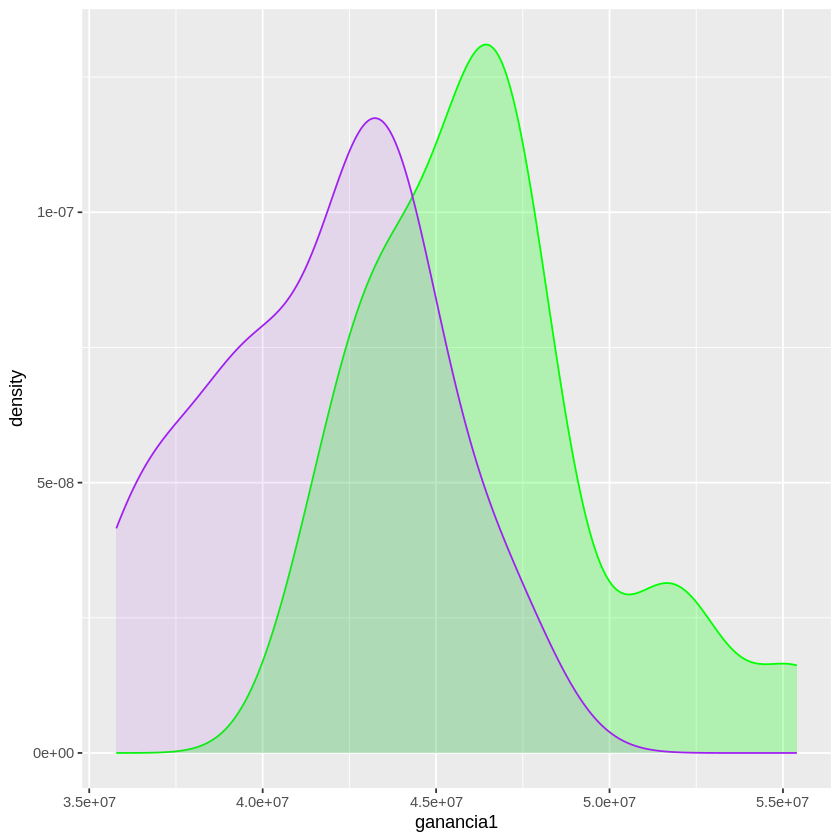

In [48]:
grafico <- ggplot( tb_salida, aes(x=ganancia1)) + geom_density(alpha=0.25, fill="green", color="green")  +
             geom_density(data=tb_salida, aes(x=ganancia2), fill="purple", color="purple",  alpha=0.10)

print(grafico)

In [49]:
# imprimo en un .pdf  que va a la carpeta del experimento
pdf("densidad_dos.pdf")
print(grafico)
dev.off()

agg_record_1957711008 
                    2

In [50]:
print( tb_salida[ , list( "arbol1" = mean( ganancia1),  "arbol2" = mean(ganancia2) ) ] )

print( tb_salida[ , list( "prob( m1 > m2)" = sum(ganancia1 > ganancia2 )/ .N ) ]  )

     arbol1   arbol2
      <num>    <num>
1: 46463500 41666500
   prob( m1 > m2)
            <num>
1:            0.9


### Acciones a realizar
* Reportar la  los resultados en la planilla colaborativa hoja  **C2-dosModelos**
* ¿Todos los alumnos hubieran elegido el mismo modelo aun con 20 semillas?



---



# 7 Comparando dos buenos  modelos
## Clase 02  Experimento 7

## 7.1  Objetivos
Presentar a los alumnos la dificultad que surge en la comparación de dos muy distintos, pero ambos buenos, modelos predictivos, y el costo computacional asociado a esa comparación
<br>Comparación simple de media de ganancias, versus probabilidad que un modelo sea superior a otro.
<br>Limitaciones de la MonteCarlo Cross Validation
<br>Existencia del Test de Wilcoxon

## 7.2 Introduccion
Estos son los dos arboles de muy distinta profundidad.
<br>¿Cuál de ellos es mejor? ¿Cuál elijo?

| Hiperparámetro | Arbol 1 | Arbol 2 |
| --- | --: |  ---: |
| cp | -1 | -1 |
|minsplit | 170 | 1900 |
|minbucket | 70 | 800 |
|maxdepth | 7 | 3 |



## 7.3 Dos buenos modelos

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

El tiempo de corrida es de alrededor de 50 minutos

limpio el ambiente de R

In [51]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1420980,75.9,2513455,134.3,2513455,134.3
Vcells,2605191,19.9,52410826,399.9,104118852,794.4


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [52]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if (!require("primes")) install.packages("primes")
require("primes")

require("ggplot2")

###  Accion a Realizar
PARAM$semilla_primigenia  debe reemplazarse por SU primer semilla

In [53]:
PARAM <- list()
PARAM$semilla_primigenia <- 102191
PARAM$qsemillas <- 50
PARAM$training_pct <- 70L     # entre 1 y 100


In [54]:
# los dos arboles
PARAM$rpart1 <- list (
  "cp" = -1,
  "minsplit" = 170,
  "minbucket" = 70,
  "maxdepth" = 7
)


PARAM$rpart2 <- list (
  "cp" = -1,
  "minsplit" = 1900,
  "minbucket" = 800,
  "maxdepth" = 3
)


In [55]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [56]:
DosArbolesEstimarGanancia <- function(semilla, training_pct, param_rpart1, param_rpart2) {
  # fuerzo impresion
  print( paste( semilla, Sys.time()) )
  flush.console()

  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(training_pct, 100L -training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo1 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart1
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion1 <- predict(modelo1, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test1 <- dataset[
    fold == 2,
    sum(ifelse(prediccion1[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 117000, -3000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada1 <- ganancia_test1 / (( 100 - training_pct ) / 100 )

  modelo2 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart2
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion2 <- predict(modelo2, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test2 <- dataset[
    fold == 2,
    sum(ifelse(prediccion2[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 117000, -3000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada2 <- ganancia_test2 / (( 100 - training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "ganancia1" = ganancia_test_normalizada1,
    "ganancia2" = ganancia_test_normalizada2
  ))
}

In [57]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp206"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [58]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [59]:
# genero numeros primos
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia) # inicializo

# me quedo con PARAM$qsemillas   semillas
PARAM$semillas <- sample(primos, PARAM$qsemillas )

In [ ]:
# la funcion mcmapply  llama a la funcion DosArbolesEstimarGanancia
#  tantas veces como valores tenga el vector  PARAM$semillas
Sys.time()

salidas <- mcmapply( DosArbolesEstimarGanancia,
  PARAM$semillas, # paso el vector de semillas
  MoreArgs = list(PARAM$training_pct, PARAM$rpart1, PARAM$rpart2), # aqui paso el segundo parametro
  SIMPLIFY = FALSE,
  mc.cores = detectCores()
)

Sys.time()

[1] "2025-10-05 16:24:25 UTC"

In [ ]:
# paso la lista a vector
tb_salida <- rbindlist(salidas)
tb_salida

In [ ]:
grafico <- ggplot( tb_salida, aes(x=ganancia1), fill="green", color="green") + geom_density(alpha=0.25)  +
             geom_density(data=tb_salida, aes(x=ganancia2), fill="purple", color="purple",  alpha=0.10)

print(grafico)

In [ ]:
# imprimo en un .pdf  que va a la carpeta del experimento
pdf("densidad_dos.pdf")
print(grafico)
dev.off()

In [ ]:
# medias de las ganancias
print( tb_salida[ , list( "arbol1" = mean( ganancia1),  "arbol2" = mean(ganancia2) ) ] )


In [ ]:
# probabilidad que m1 sea mayor a m2
print( tb_salida[ , list( "prob( m1 > m2)" = sum(ganancia1 > ganancia2 )/ .N ) ]  )

### Acciones a realizar
* Reportar la  los resultados en la planilla colaborativa hoja  **C2-dosBuenos**




---



# 8 Test de Wilcoxon
## Clase 02  Experimento 8

## 8.1  Objetivos

¿Como calcular la cantidad mínima de semillas que hacen falta para tener cierta certeza que un modelo es superior a otro?

## 8.2  Introduccion

| Hiperparámetro | Arbol 1 | Arbol 2 |
| --- | --: |  ---: |
| cp | -1 | -1 |
|minsplit | 170 | 250 |
|minbucket | 70 | 125 |
|maxdepth | 7 | 20 |

<br>
<br>


| ordinal | semilla | ganancia1 | ganancia2 | p-value |
| --- | --- |  --- |  --- |  --- |
| 1 |378821 | 41,470,000 | 37,790,000 | 1.000 |
| 2 | 964333  | 48,480,000  | 43,660,000 | 0.500 |
| 3 | 187049 | 50,610,000 | 47,840,000 | 0.250 |
| 4 | 205151 | 45,580,000 | 44,490,000 | 0.125 |
| 5 | 813697 | 52,780,000 | 46,750,000 |  0.063 |
| 6 | 344719 | 49,970,000 | 44,300,000 | 0.031 |
|7 |127217  |52,810,000 | 42,840,000 |0.016 |
| 8 | 464371 | 43,060,000 | 37,300,000 | 0.008 |
| 9 | 645137 | 49,660,000 |43,730,000 | 0.004|




## 8.3 Codigo Test de Wilcoxon

In [ ]:
# 1 sola ganancia
wilcox.test(
  c(41470000),
  c(37790000),
  paired = TRUE
)


In [ ]:
# 2 ganancias
wilcox.test(
  c(41470000, 48480000),
  c(37790000, 43660000),
  paired = TRUE
)


In [ ]:
# 3 ganancias
wilcox.test(
  c(41470000, 48480000, 50610000),
  c(37790000, 43660000, 47840000),
  paired = TRUE
)

In [ ]:
# 4 ganancias
wilcox.test(
  c(41470000, 48480000, 50610000, 45580000),
  c(37790000, 43660000, 47840000, 44490000),
  paired = TRUE
)


In [ ]:
# 5 ganancias
wilcox.test(
  c(41470000, 48480000, 50610000, 45580000, 52780000),
  c(37790000, 43660000, 47840000, 44490000, 46750000),
  paired = TRUE
)

In [ ]:
# 6 ganancias
wilcox.test(
  c(41470000, 48480000, 50610000, 45580000, 52780000, 49970000),
  c(37790000, 43660000, 47840000, 44490000, 46750000, 44300000),
  paired = TRUE
)

In [ ]:
# Finalmente el p-value es  0.03125  < 0.05
# hicieron falta  SEIS semillas, seis ganancias, para
#   afirmar que el modelo 1 es superior al modelo 2

# 7 ganancias
wilcox.test(
  c(41470000, 48480000, 50610000, 45580000, 52780000, 49970000, 52810000),
  c(37790000, 43660000, 47840000, 44490000, 46750000, 44300000, 42840000),
  paired = TRUE
)


In [ ]:
# 8 ganancias
wilcox.test(
  c(41470000, 48480000, 50610000, 45580000, 52780000, 49970000, 52810000, 43060000),
  c(37790000, 43660000, 47840000, 44490000, 46750000, 44300000, 42840000, 37300000),
  paired = TRUE
)


In [ ]:
# 9 ganancias
wilcox.test(
  c(41470000, 48480000, 50610000, 45580000, 52780000, 49970000, 52810000, 43060000, 49660000),
  c(37790000, 43660000, 47840000, 44490000, 46750000, 44300000, 42840000, 37300000, 43730000),
  paired = TRUE
)



---



# 9 Comparando automaticamente modelos con test de Wilcoxon
## Clase 02  Experimento 9

## 9.1  Objetivos

Proveer un script que permita comparar dos arboles de decisión con la librería rpart utilizando la menor cantidad de cómputo que permita el Test de Wilxcoxon

## 9.2  Introduccion

| Hiperparámetro | Arbol 1 | Arbol 2 |
| --- | --- |  --- |
| cp | -1 | -1 |
|minsplit | 1050 | 650 |
|minbucket | 550 | 300 |
|maxdepth |67 | 6 |




## 9.3 Codigo comparacion automatica Wilcoxon

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [ ]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if (!require("primes")) install.packages("primes")
require("primes")

require("ggplot2")

###  Accion a Realizar
PARAM$semilla_primigenia  debe reemplazarse por SU primer semilla

In [ ]:
PARAM <- list()
PARAM$semilla_primigenia <- 102191
PARAM$qsemillas_tope <- 50
PARAM$training_pct <- 70L     # entre 1 y 100


In [ ]:
# los dos arboles
PARAM$rpart1 <- list (
  "cp" = -1,
  "minsplit" = 800,
  "minbucket" = 400,
  "maxdepth" = 7
)


PARAM$rpart2 <- list (
  "cp" = -1,
  "minsplit" = 650,
  "minbucket" = 300,
  "maxdepth" = 6
)


In [ ]:
# particionar agrega una columna llamada fold a un dataset
#  que consiste en una particion estratificada segun agrupa

# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(
    data, division, agrupa = "",
    campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(function(x, y) {
    rep(y, x)
  }, division, seq(from = start, length.out = length(division))))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by = agrupa
  ]
}


In [ ]:
DosArbolesEstimarGanancia <- function(semilla, training_pct, param_rpart1, param_rpart2) {
  # particiono estratificadamente el dataset
  particionar(dataset,
    division = c(training_pct, 100L -training_pct),
    agrupa = "clase_ternaria",
    seed = semilla # aqui se usa SU semilla
  )

  # genero el modelo
  # predecir clase_ternaria a partir del resto
  modelo1 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart1
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion1 <- predict(modelo1, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test1 <- dataset[
    fold == 2,
    sum(ifelse(prediccion1[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 117000, -3000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada1 <- ganancia_test1 / (( 100 - training_pct ) / 100 )

  modelo2 <- rpart("clase_ternaria ~ .",
    data = dataset[fold == 1], # fold==1  es training,  el 70% de los datos
    xval = 0,
    control = param_rpart2
  ) # aqui van los parametros del arbol

  # aplico el modelo a los datos de testing
  prediccion2 <- predict(modelo2, # el modelo que genere recien
    dataset[fold == 2], # fold==2  es testing, el 30% de los datos
    type = "prob"
  ) # type= "prob"  es que devuelva la probabilidad


  # calculo la ganancia en testing  qu es fold==2
  ganancia_test2 <- dataset[
    fold == 2,
    sum(ifelse(prediccion2[, "BAJA+2"] > 0.025,
      ifelse(clase_ternaria == "BAJA+2", 117000, -3000),
      0
    ))
  ]

  # escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada2 <- ganancia_test2 / (( 100 - training_pct ) / 100 )

  return(list(
    "semilla" = semilla,
    "ganancia1" = ganancia_test_normalizada1,
    "ganancia2" = ganancia_test_normalizada2
  ))
}

In [ ]:
# 1  ->  el modelo 1 es mejor
# 2  ->  el modelo 2 es mejor
# 0  ->  No se pudo determinar con el tope de qsemillas_tope


MejorArbol <- function( qsemillas_tope, training_pct, param_rpart1, param_rpart2) {

  # genero numeros primos
  primos <- generate_primes(min = 100000, max = 1000000)
  set.seed(PARAM$semilla_primigenia) # inicializo
  # me quedo con PARAM$qsemillas   semillas
  semillas <- sample(primos, qsemillas_tope )

  pvalue <- 1.0
  isem <- 1
  vgan1 <- c() # almaceno ganancias del modelo1
  vgan2 <- c() # almaceno ganancias del modelo2

  while( (isem <= qsemillas_tope)  & (pvalue > 0.05) ) {

    res <- DosArbolesEstimarGanancia(
       semillas[ isem ],
       training_pct,
       param_rpart1,
       param_rpart2
    )

    vgan1 <- c( vgan1, res$ganancia1 )
    vgan2 <- c( vgan2, res$ganancia2 )

    wt <- wilcox.test( vgan1, vgan2, paired=TRUE )
    pvalue <- wt$p.value

    cat( isem, res$ganancia1, res$ganancia2, pvalue, "\n" )
    flush.console()
    isem <- isem + 1
  }

  out <- 0

  if( pvalue < 0.05 & mean(vgan1) > mean(vgan2)  )  out <- 1
  if( pvalue < 0.05 & mean(vgan1) < mean(vgan2)  )  out <- 2


  return( list( "out" = out,
    "qsemillas" = length(vgan1),
    "m1" = mean( vgan1 ),
    "m2" = mean( vgan2 )
   ) )
}


In [ ]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp209"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [ ]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

# trabajo solo con los datos con clase, es decir 202107
dataset <- dataset[clase_ternaria != ""]

In [ ]:
Sys.time()

comparacion <- MejorArbol(
   PARAM$qsemillas_tope,
   PARAM$training_pct,
   PARAM$rpart1,
   PARAM$rpart2
 )


print( comparacion )

Sys.time()

### Acciones a realizar
* Reportar la  los resultados en la planilla colaborativa hoja  **C2-Wilcox**




---

